In [2]:
import pandas as pd

df = pd.read_csv('positive.csv', na_values=['NULL'])

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                              12SL_Codes Source  \
0   HR00008       22,542,1665,533,1666,780,831,1699  PTBXL   
1   HR00077                         22,964,821,1699  PTBXL   
2   HR00085  22,542,1665,531,1666,1682,740,831,1699  PTBXL   
3   HR00103                     23,470,780,831,1699  PTBXL   
4   HR00128                    22,1682,780,831,1699  PTBXL   

                                          Phys_Codes  MI_12SL  MI_Phys  \
0          164865005, 164951009, 39732003, 426783006        1        1   
1                     426783006, 54329005, 713426002        1        1   
2                                          426783006        1        0   
3  164865005, 164951009, 39732003, 427084000, 445...        1        1   
4                                          164934002        1        0   

   TestID  PatientAge  Gender AcquisitionDateTime_DT  ...  STDOWN_V6  \
0       8         NaN     NaN    2020-04-23 07:59:54  ...          0   
1      77         NaN     NaN    2020-

In [3]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [4]:
y = df['MI_Phys']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys']), y, test_size=0.2, random_state=42)

y_12SL = X_test['MI_12SL']

#drop the 12SL column
X_test = X_test.drop(columns=['MI_12SL'])
X_train = X_train.drop(columns=['MI_12SL'])




In [5]:
#count number of positive and negative smales based on MI_Phys
print(df['MI_Phys'].value_counts())

MI_Phys
0    5419
1    4003
Name: count, dtype: int64


In [6]:
estimators = [0.15, 0.11, 0.1, 0.09, 0.08, 0.07]
leaves = [15, 31, 63, 127]
scores = {}
for estims in estimators:
    for num_leaves in leaves:
        lgb_params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'n_estimators': 50,
            'learning_rate': estims,
            'random_state': 42,
            'verbose': -1,
            'num_leaves': num_leaves,
            'scale_pos_weight': 5419/4003,
            }
        model = (lgb.LGBMClassifier(**lgb_params))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='micro')
        scores[(estims, num_leaves)] = score
        print(f"Learning rate: {estims}, Number of Leaves: {num_leaves} F1 score: {score:.4f}")

Learning rate: 0.15, Number of Leaves: 15 F1 score: 0.8090
Learning rate: 0.15, Number of Leaves: 31 F1 score: 0.8053
Learning rate: 0.15, Number of Leaves: 63 F1 score: 0.8133
Learning rate: 0.15, Number of Leaves: 127 F1 score: 0.8202
Learning rate: 0.11, Number of Leaves: 15 F1 score: 0.8069
Learning rate: 0.11, Number of Leaves: 31 F1 score: 0.8027
Learning rate: 0.11, Number of Leaves: 63 F1 score: 0.8074
Learning rate: 0.11, Number of Leaves: 127 F1 score: 0.8133
Learning rate: 0.1, Number of Leaves: 15 F1 score: 0.7995
Learning rate: 0.1, Number of Leaves: 31 F1 score: 0.8127
Learning rate: 0.1, Number of Leaves: 63 F1 score: 0.8101
Learning rate: 0.1, Number of Leaves: 127 F1 score: 0.8085
Learning rate: 0.09, Number of Leaves: 15 F1 score: 0.8021
Learning rate: 0.09, Number of Leaves: 31 F1 score: 0.8058
Learning rate: 0.09, Number of Leaves: 63 F1 score: 0.8080
Learning rate: 0.09, Number of Leaves: 127 F1 score: 0.8149
Learning rate: 0.08, Number of Leaves: 15 F1 score: 0.79

In [7]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.15,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    'scale_pos_weight': 5419/4003,
    }
model = (lgb.LGBMClassifier(**lgb_params))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.8286472148541114


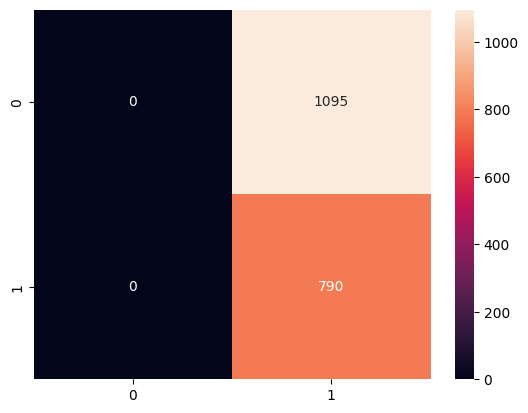

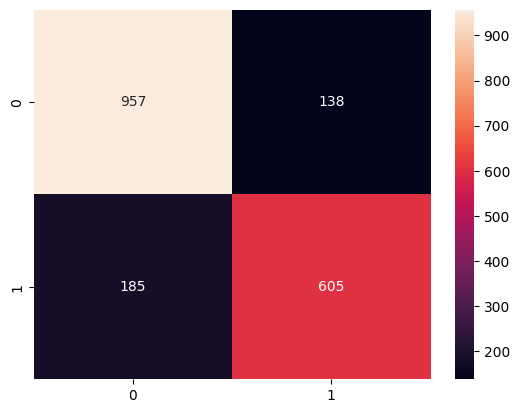

In [8]:
#confusion matrix 12SL (no model)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(y_test, y_12SL)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


#confusion matrix (from model)


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

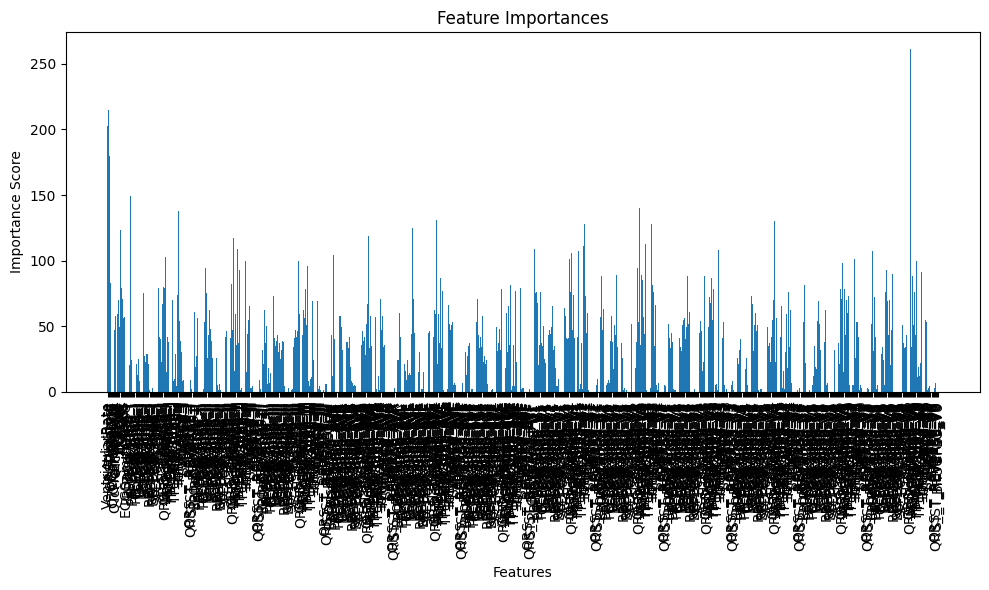

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your trained LightGBM model
importances = model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(len(importances))

# Create a bar plot of the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


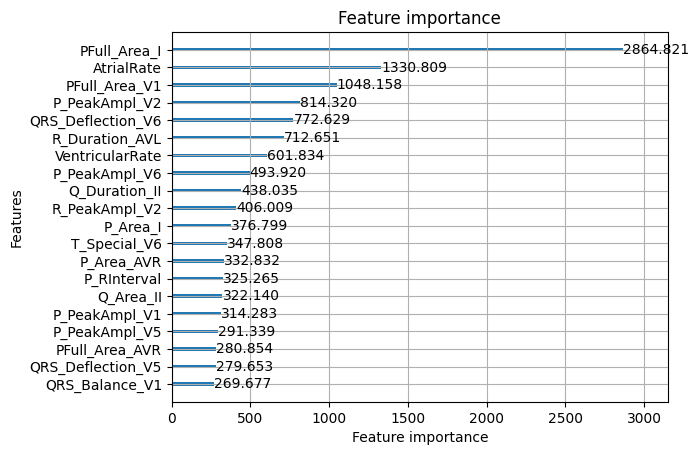

In [10]:
# 'gbm' is the model returned by lgb.train
booster = model.booster_
importances = booster.feature_importance(importance_type='split')  # or use 'gain'
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


Number of components selected: 258
Total variance explained: 0.950074898961981
Variance explained by each component: [0.05234983 0.04810223 0.04152874 0.04029647 0.03652462 0.0319282
 0.02675475 0.02519255 0.02148077 0.02096476 0.01836165 0.01544834
 0.01528497 0.01330598 0.01268838 0.01227724 0.0113005  0.01039591
 0.00952788 0.00939517 0.00874377 0.00862859 0.00822804 0.00790863
 0.00771942 0.00747395 0.00703296 0.0068551  0.00678123 0.0065472
 0.00641391 0.0061666  0.005963   0.00572796 0.00559445 0.00556762
 0.00552405 0.00546888 0.00530289 0.00512413 0.00499148 0.00494456
 0.00474549 0.00470799 0.00459161 0.00451788 0.0044673  0.00442298
 0.0042918  0.00423117 0.00404036 0.00401622 0.00394807 0.00390832
 0.00382798 0.00377682 0.00369477 0.00367364 0.00359758 0.00355109
 0.00349361 0.00344246 0.00337948 0.00334372 0.00328781 0.00323189
 0.003184   0.0030967  0.00307583 0.00303963 0.00295354 0.00290051
 0.00287873 0.0028339  0.00279607 0.00277101 0.00271328 0.00267692
 0.00267394 0.

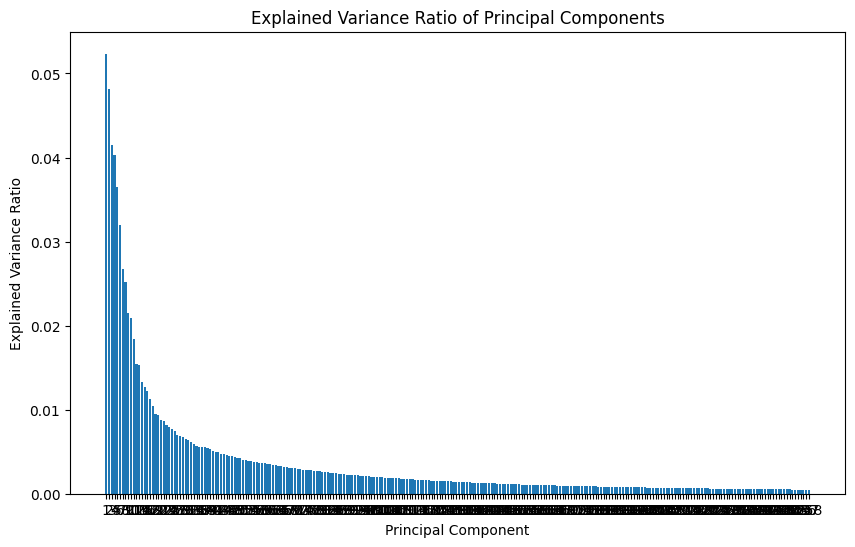

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cols = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys'])
# drop NaN values
df_cols = df_cols.dropna()
X_scaled = scaler.fit_transform(df_cols)

pca = PCA(n_components=0.95, random_state=42)  # keep 95% of variance
principal_components = pca.fit_transform(X_scaled)

print("Number of components selected:", pca.n_components_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())
print("Variance explained by each component:", pca.explained_variance_ratio_)
print("Principal components shape:", principal_components.shape)
#column names from original data
feature_names = df_cols.columns
# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio of Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, pca.n_components_ + 1))
plt.show()

In [12]:
df_cols_Y = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT'])
# drop NaN values
df_cols_Y = df_cols_Y.dropna()
y = df_cols_Y['MI_Phys']
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=42)



In [13]:
estimators = [0.25, 0.2, 0.15, 0.1, 0.09]
leaves = [15, 31, 63, 127]
scores = {}
for estims in estimators:
    for num_leaves in leaves:
        lgb_params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'n_estimators': 100,
            'learning_rate': estims,
            'random_state': 42,
            'verbose': -1,
            'num_leaves': num_leaves,
            }
        model = (lgb.LGBMClassifier(**lgb_params))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='micro')
        scores[(estims, num_leaves)] = score
        print(f"Learning rate: {estims}, Number of Leaves: {num_leaves} F1 score: {score:.4f}")

Learning rate: 0.25, Number of Leaves: 15 F1 score: 0.7622
Learning rate: 0.25, Number of Leaves: 31 F1 score: 0.7629
Learning rate: 0.25, Number of Leaves: 63 F1 score: 0.7636
Learning rate: 0.25, Number of Leaves: 127 F1 score: 0.7593
Learning rate: 0.2, Number of Leaves: 15 F1 score: 0.7702
Learning rate: 0.2, Number of Leaves: 31 F1 score: 0.7658
Learning rate: 0.2, Number of Leaves: 63 F1 score: 0.7745
Learning rate: 0.2, Number of Leaves: 127 F1 score: 0.7636
Learning rate: 0.15, Number of Leaves: 15 F1 score: 0.7724
Learning rate: 0.15, Number of Leaves: 31 F1 score: 0.7651
Learning rate: 0.15, Number of Leaves: 63 F1 score: 0.7745
Learning rate: 0.15, Number of Leaves: 127 F1 score: 0.7673
Learning rate: 0.1, Number of Leaves: 15 F1 score: 0.7738
Learning rate: 0.1, Number of Leaves: 31 F1 score: 0.7585
Learning rate: 0.1, Number of Leaves: 63 F1 score: 0.7615
Learning rate: 0.1, Number of Leaves: 127 F1 score: 0.7702
Learning rate: 0.09, Number of Leaves: 15 F1 score: 0.7542
L

In [14]:

lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.1,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    }
model = (lgb.LGBMClassifier(**lgb_params))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print(f"F1 score: {score:.4f}")

F1 score: 0.7789


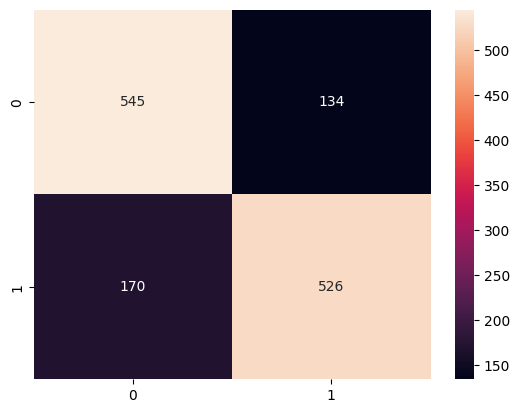

In [15]:
#confusion matrix 12SL (no model)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# cm = confusion_matrix(y_test, y_12SL)
# sns.heatmap(cm, annot=True, fmt='d')
# plt.show()


#confusion matrix (from model)


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [16]:
from imblearn.over_sampling import SMOTE

# Rebalance training data using SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTE class distribution:\n", y_train.value_counts())
print("After SMOTE class distribution:\n", y_train_bal.value_counts())

Before SMOTE class distribution:
 MI_Phys
0    2786
1    2712
Name: count, dtype: int64
After SMOTE class distribution:
 MI_Phys
0    2786
1    2786
Name: count, dtype: int64
